# Benchmark Model

**Purpose of script:**

Define a benchmark model for performance comparisons

### Data Prep

Imports:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score

from functions import read_and_prep_parquet
from functions import get_rmse
from functions import save_prediction_tif

Relevant paths:

In [2]:
df_path = r"../Data/combined/pandas_extended/"

out_path_regression =  r"../Data/results/regression/"
out_path_classification =  r"../Data/results/classification/"


Import and prep data:

In [3]:
# X_train, y_train = read_and_prep_parquet(df_path + 'melt_2019-07-02_extended.parquet.gzip', 'train')
# X_test, y_test = read_and_prep_parquet(df_path + 'melt_2019-07-02_extended.parquet.gzip', 'test')

Train:

In [3]:
train_datelist = pd.date_range(start="2019-06-01",end="2019-06-30")
train_datelist = [str(day.date()) for day in train_datelist]

X_train_df_list = []
y_train_df_list = []

for day in train_datelist:
    try: # bc some days are empty
        X_train, y_train = read_and_prep_parquet(df_path + 'melt_' + day + '_extended.parquet.gzip', 'train')
        print(day)
        #X_train_df_list.append(X_train)
        y_train_df_list.append(y_train)
    except:
        continue


#X_train = pd.concat(X_train_df_list, axis=0)
y_train = pd.concat(y_train_df_list, axis=0)

2019-06-08
2019-06-10
2019-06-11
2019-06-12
2019-06-13
2019-06-14
2019-06-15
2019-06-16
2019-06-17
2019-06-18
2019-06-19
2019-06-20
2019-06-21
2019-06-22
2019-06-23
2019-06-24
2019-06-25
2019-06-26
2019-06-27
2019-06-28
2019-06-29
2019-06-30


In [4]:
len(y_train)

20862118

In [5]:
del X_train_df_list
del y_train_df_list


Test:

In [ ]:
test_datelist = pd.date_range(start="2019-07-01",end="2019-07-14")
test_datelist = [str(day.date()) for day in test_datelist]

X_test_df_list = []
y_test_df_list = []

for day in test_datelist:
    try: # bc some days are empty
        X_train, y_train = read_and_prep_parquet(df_path + 'melt_' + day + '_extended.parquet.gzip', 'train')
        print(day)
        X_test_df_list.append(X_train)
        y_test_df_list.append(y_train)
    except:
        continue


X_test = pd.concat(X_test_df_list, axis=0)
y_test = pd.concat(y_test_df_list, axis=0)

In [7]:
del X_test_df_list
del y_test_df_list

### Baseline Regression

In [8]:
y_predicted = np.full((1, len(y_test)), y_train.mean())[0]

In [9]:
rmse = get_rmse(y_test, y_predicted)
rmse # 0.40747648

0.38437453

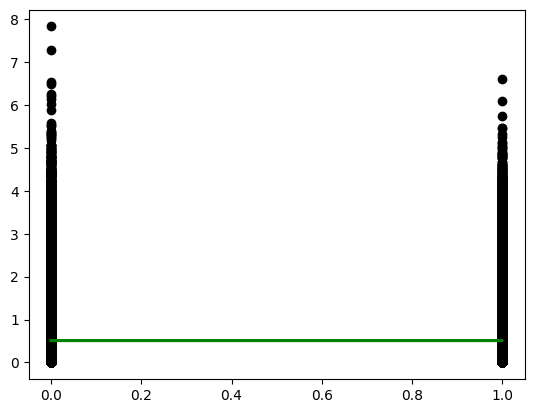

In [19]:
plt.scatter(X_test['mw_value'], y_test,  color='black')
plt.plot(X_test['mw_value'], y_predicted, color='green', linewidth=2)

Predict

In [10]:
# no need to plot bc its all the same value, also no need to loop over all days bc mean benchmark will give same to all.

X_pred = read_and_prep_parquet(df_path + 'melt_2019-07-15_extended.parquet.gzip', 'predict')
y_predicted_out = np.full((1, len(X_pred)), y_train.mean())[0]


In [17]:
path_out = out_path_regression + 'prediction_benchmark_.tif'

save_prediction_tif(X_pred, y_predicted_out, path_out)

2278725it [01:42, 22280.16it/s]


### Baseline Classification

#### Binary classification

predict majority class

In [8]:
# melt threshold in paper - 0.64
print(f'melt percent in opt data {(y_train >= 0.64).sum()/len(y_train)}')
print(f'melt percent in mw data {(X_train["mw_value"] == 1).sum()/len(X_train)}')

melt percent in opt data opt_value    0.161283
dtype: float64
melt percent in mw data 0.2680629750944592


In [9]:
y_predicted = np.full((1, len(y_test)), 0)[0]
y_test_classes = [1 if i >= 0.64 else 0 for i in y_test['opt_value']]

In [10]:
accuracy = accuracy_score(y_test_classes, y_predicted)
accuracy


0.8011163968191477

#### Multiclass (buckets) classification

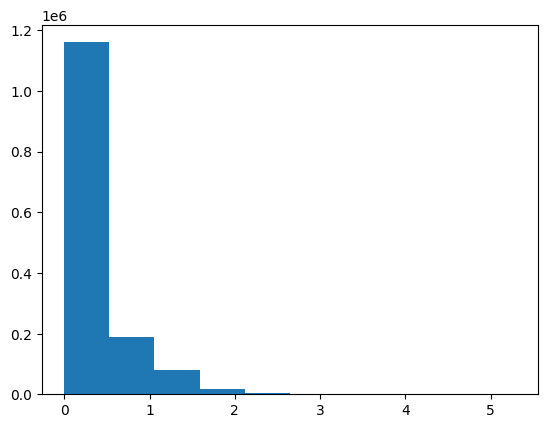

In [ ]:
#plt.hist(df['opt_value'])
plt.hist(y_train);

11 buckets every 0.2 and all over 2

In [11]:
y_train['binned_opt_value'] = pd.cut(y_train['opt_value'], 
                                    list(np.arange(0, 0.41, 0.2)) 
                                    + [0.64] 
                                    + list(np.arange(0.8, 2.01, 0.2)) 
                                    + [100.0])


In [12]:
buckets = list(y_train['binned_opt_value'].unique())
buckets.sort()
num_buckets = len(buckets)
value_bucket_lookup = dict(zip(buckets, range(num_buckets)))

In [13]:
y_train['binned_opt_value_code'] = y_train['binned_opt_value'].replace(value_bucket_lookup).values

In [14]:
# find largest bucket and predict for all that
y_train['binned_opt_value_code'].value_counts()
# largest - bin 1


1     707224
2     266179
0     244150
4      60777
3      53872
5      46465
6      31046
7      19797
8      10515
10      6537
9       5123
Name: binned_opt_value_code, dtype: int64

In [15]:
# same for test
y_test['binned_opt_value'] = pd.cut(y_test['opt_value'], 
                                    list(np.arange(0, 0.41, 0.2)) 
                                    + [0.64] 
                                    + list(np.arange(0.8, 2.01, 0.2)) 
                                    + [100.0])
buckets_test = list(y_test['binned_opt_value'].unique())

In [16]:
# if np.isnan(buckets_test[-1]):
#     buckets_test = buckets_test[:-1]
buckets_test.sort() # cannot sort if has nan.


In [17]:
num_buckets_test = len(buckets_test)
value_bucket_lookup_test = dict(zip(buckets_test, range(num_buckets_test)))
y_test['binned_opt_value_code'] = y_test['binned_opt_value'].replace(value_bucket_lookup_test).values

In [18]:
# predict
y_predicted = np.full((1, len(y_test)), 1)[0]

accuracy = accuracy_score(y_test['binned_opt_value_code'], y_predicted)
accuracy

0.4583349914797496

In [19]:
# predict on prediction file and write?

X_pred = read_and_prep_parquet(df_path + 'melt_2019-06-15_extended.parquet.gzip', 'predict')
y_predicted_out = np.full((1, len(X_pred)), 1)[0]

path_out = out_path_classification + 'prediction_benchmark_multiclass.tif'

save_prediction_tif(X_pred, y_predicted_out, path_out)

2278725it [01:46, 21345.63it/s]


: 